## Model & Instruction Guide

### Overview
This script builds a Random Geometric Graph (RGG), samples commute-time resistances between node pairs,
fits a LASSO regression model to predict resistance from geometric features, and visualises the results.

---

### Key Configuration Variables

| Variable | What it controls |
|---|---|
| `SPACE` | Graph geometry. `"torus"` wraps edges (recommended for avoiding boundary effects). Other options: `"unit_square"`, `"square_torus"`, `"triangular_torus"` |
| `USE_ANGLES` | If `True`, includes angular information in sampling, enabling the `d^4 * cos(4θ)` feature |
| `FEATURES` | Feature set used in regression. See **Feature Sets** below |
| `LASSO_ALPHA` | Regularisation strength. Lower = less shrinkage. `1e-6` is near-OLS. Increase if all coefficients collapse to zero |
| `CONNECTIVITY_REGIME` | `"sc"` = super critical, `"c"` = connected only |
| `ORDER` | Lattice order for square/triangular spaces — controls which shells of neighbours are included |
| `PERTURB` | `True` adds positional noise to lattice nodes through bivariate normals, breaking perfect symmetry |
| `PERTURB_SCALE` | standard deviation of positional noise (only active when `PERTURB=True`) |
| `N_NODES` | Number of nodes in the graph |
| `K_NEIGHBORS` | Target mean degree |
| `N_SAMPLES` | Number of node pairs sampled for regression |
| `ITERATION` | Random seed — change to get a different graph instance |

---

### Feature Sets

**`"lattice_with_no_perturbation"`** — use when `PERTURB=False` (perfect lattice):
```
Log(Dist)        →  captures long-range logarithmic growth of resistance
Dist^2           →  captures local quadratic term
d^4 * cos(4θ)    →  captures 4-fold rotational symmetry of the square lattice
```

**`"default"`** — use when `PERTURB=True` (disordered graph):
```
All of the above, plus:
InvDegSum         →  1/deg(u) + 1/deg(v), corrects for degree heterogeneity
                     introduced by perturbation breaking the uniform-degree lattice
```

> **Rule of thumb:** match `FEATURES` to `PERTURB`. The `InvDegSum` feature has no
> signal on a perfect lattice (all degrees are equal) and should be excluded there.

---

### Output Panels

| Panel | What to look for |
|---|---|
| **Feature Importance (Scaled)** | Which features LASSO kept. Bars at zero = feature was shrunk out |
| **Model Fit (R²)** | Points should hug the red diagonal. Colour shows `InvDegSum` — if the fit is poor only for high/low values, a degree-correction feature may be missing |
| **Residuals vs Distance** | Should be flat around zero. A visible curve means a distance-dependent feature is missing |
| **3D Profile** | Visualises the joint structure of distance, degree-sum, and resistance. Black = predicted, coloured = observed |

---

### Example Workflow

1. **Start with a perfect lattice** — set `PERTURB=False`, `FEATURES="lattice_with_no_perturbation"`.
   Expect high R² if the geometry is clean.

2. **Introduce perturbation** — set `PERTURB=True`, `FEATURES="default"` to add `InvDegSum`.
   R² should remain high; a drop signals the degree correction is insufficient.

3. **Tune `PERTURB_SCALE`** — as values grow becomes a good approximation for a fully random graph. 
   Watch R² and the residuals panel degrade as order breaks down.

4. **Change seeds** — increment `ITERATION` to test robustness across different graph instances.

5. **Scale up** — increase `N_SAMPLES` together for more reliable coefficient estimates.
   Runtime scales roughly as O(N²) for resistance calculations.


===== SEED 0 =====
Graph Statistics:
  Radius: 0.079828
  Nodes: 1000
  Edges: 9977
  Average degree: 19.954
  Min degree: 7
  Max degree: 33
  Density: 0.019974
  Avg clustering coefficient: 0.5893
  Largest component size: 100.00%


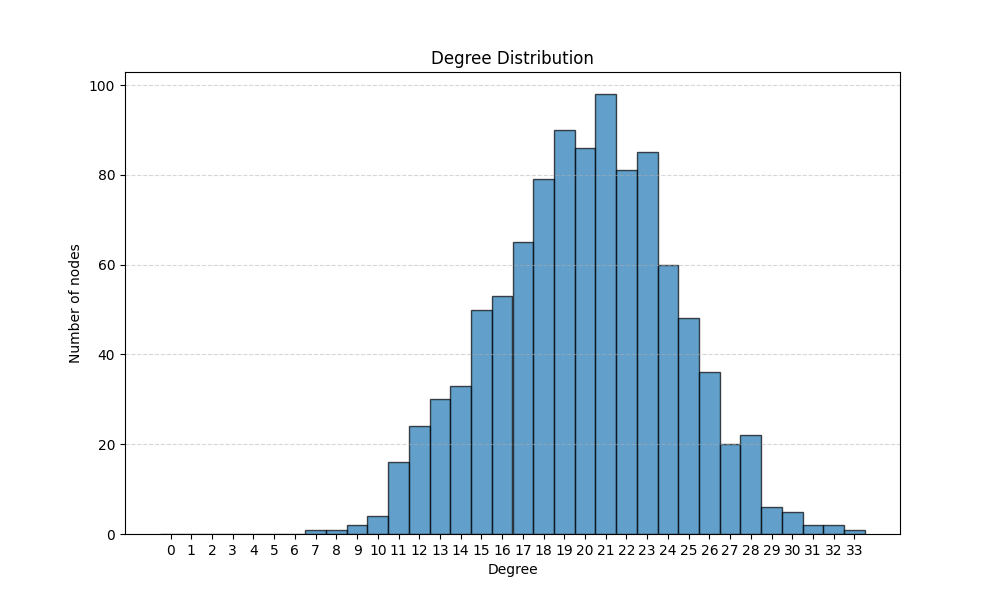


--- Running Lasso ---

Alpha (User-defined): 0.000001
Lasso R² (Calculated from Real Coefs): 0.9495

[Scaled] Feature Importance (Relative Strength):
--------------------------------------------------
InvDegSum            : 0.021863
Log(Dist)            : 0.014136
Dist^2               : -0.005108
d^4 * cos(4theta)    : -0.000703
--------------------------------------------------

[Unscaled] Physical Formula (True Units):
Real Intercept       : 0.053284
--------------------------------------------------
InvDegSum            : 1.18430465
Log(Dist)            : 0.02520844
Dist^2               : -0.03532542
d^4 * cos(4theta)    : -0.00989916
--------------------------------------------------


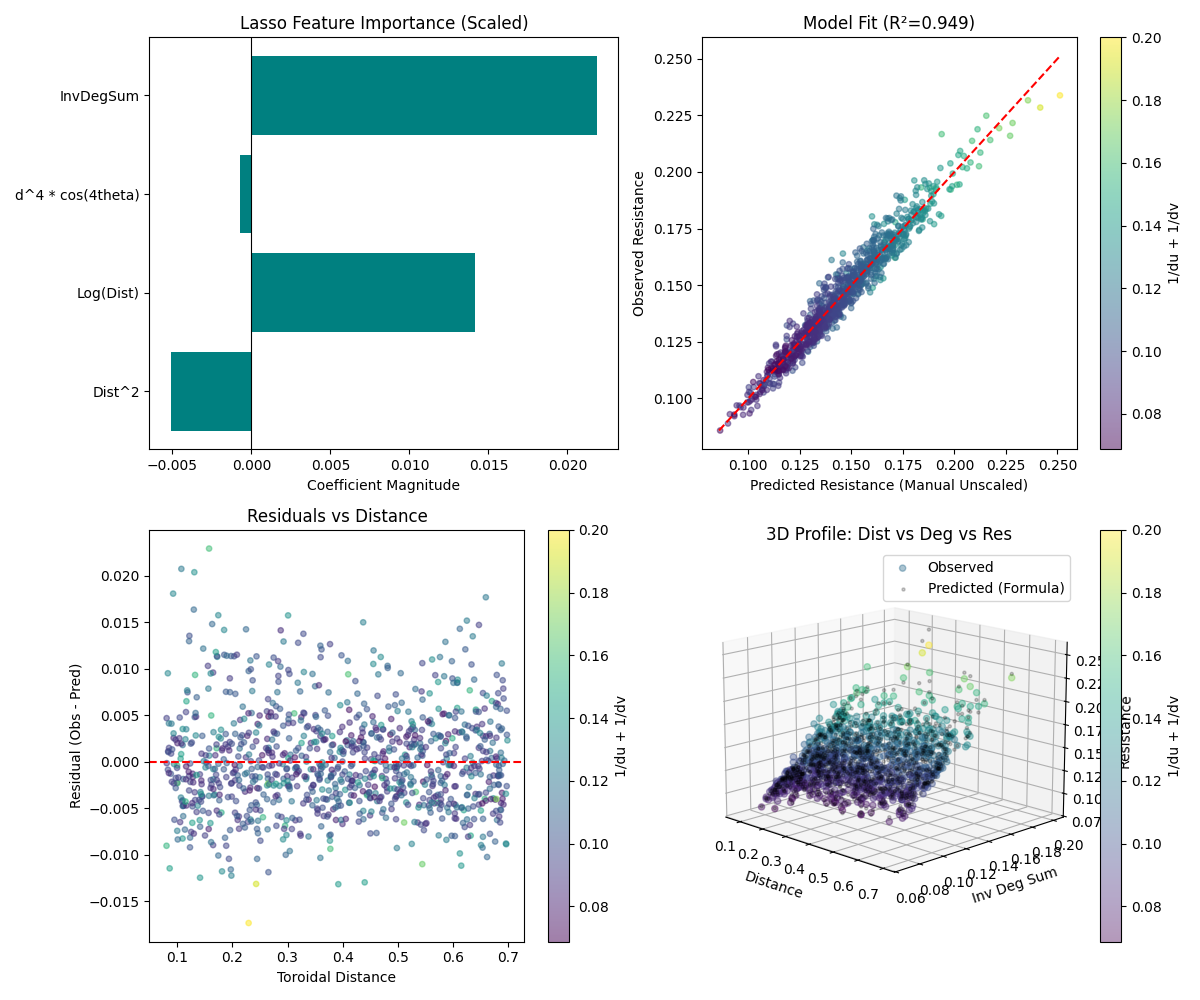

In [9]:
%matplotlib widget

import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import warnings
import sys, os, webbrowser
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from RGG_Library import RGGBuilder, RGGVisualizer

# --------------------------------------------------------------------------------
# HELPER FUNCTIONS
# --------------------------------------------------------------------------------
def radius_multiplier_calc_square_lattice(dist, exp_k):
    return np.sqrt(exp_k / (dist**2 * np.pi))

# --------------------------------------------------------------------------------
# CONFIGURATION
# --------------------------------------------------------------------------------
SPACE                       = ["torus", "unit_square", "square_torus", "triangular_torus"][0]
USE_ANGLES                  = [True, False][0]
FEATURES                    = ["default", "lattice_with_no_perturbation"][0]
LASSO_ALPHA                 = 1e-6
CONNECTIVITY_REGIME         = ["sc","c"][0]

ORDER                       = 4
MAX_DIST_FOR_ORDER          = np.sqrt(5)
DEGREE_FOR_ORDER            = 20

PERTURB                     = [True, False][1]
PERTURB_SCALE               = 1
PERTURB_RADIUS_MULTIPLIER   = radius_multiplier_calc_square_lattice(dist=MAX_DIST_FOR_ORDER, exp_k=DEGREE_FOR_ORDER)

N_NODES                     = 1000
K_NEIGHBORS                 = 20
N_SAMPLES                   = 1000
ITERATION                   = 0

# --------------------------------------------------------------------------------
# SIMULATION
# --------------------------------------------------------------------------------
def run_simulation(n=N_NODES, k=K_NEIGHBORS, nsamples=N_SAMPLES, iteration=ITERATION):
    print(f"\n===== SEED {iteration} =====")

    # --- RGG Generation ---
    builder = RGGBuilder(
        n=n, 
        k=k,
        connectivity_regime=CONNECTIVITY_REGIME,
        space=SPACE,
        order=ORDER,
        perturb=PERTURB,
        perturb_scale=PERTURB_SCALE,
        perturb_radius_multiplier=PERTURB_RADIUS_MULTIPLIER,
        seed=iteration
    )

    G = builder.build()

    # --- Ensure Giant Component ---
    if not nx.is_connected(G):
        components = list(nx.connected_components(G))
        Gsub = G.subgraph(max(components, key=len)).copy() if components else None
        if Gsub is None:
            print(f"Warning: Graph is empty in iteration {iteration}. Skipping.")
            return
    else:
        Gsub = G

    Gsub = nx.convert_node_labels_to_integers(Gsub, ordering="sorted")

    builder.print_graph_stats(G, radius=builder.radius)
    builder.plot_degree_distribution(Gsub)

    # --- Sampling ---
    random.seed(iteration)
    np.random.seed(iteration)

    if USE_ANGLES:
        res, degs, dists, pairs, angles = RGGBuilder.sample_commute_times_even_distance_w_angles(
            Gsub, nsamples=nsamples, n_bins=20, seed=iteration,
            min_dist=builder.radius, max_dist=2
        )
    else:
        res, degs, dists, pairs = RGGBuilder.sample_commute_times_even_distance(
            Gsub, nsamples=nsamples, n_bins=20, seed=iteration,
            min_dist=builder.radius, max_dist=2
        )

    if len(res) < 10:
        print("Not enough samples for Lasso regression.")
        return G, Gsub

    # --- Feature Engineering ---
    safe_dists = dists.copy()
    safe_dists[safe_dists == 0] = 1e-9
    current_angles = angles if USE_ANGLES else np.zeros_like(dists)

    if FEATURES == "default":  # "default" — lattice with no perturbation
        feature_dict = {
            "Dist^2":            dists**2,
            "Log(Dist)":         np.log(safe_dists),
            "d^4 * cos(4theta)": dists**4 * np.cos(4 * current_angles),
            "InvDegSum":         degs,
        }
    
    elif FEATURES == "lattice_with_no_perturbation":
        feature_dict = {
            "Log(Dist)":         np.log(safe_dists),
            "Dist^2":            dists**2,
            "d^4 * cos(4theta)": dists**4 * np.cos(4 * current_angles),
        }

    feature_names = list(feature_dict.keys())
    X = np.column_stack(list(feature_dict.values()))
    y = res

    # --- Lasso Regression ---
    print("\n--- Running Lasso ---")
    model = make_pipeline(
        StandardScaler(),
        Lasso(alpha=LASSO_ALPHA, random_state=0, max_iter=50000)
    )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X, y)

    # --- Extract Coefficients ---
    lasso  = model.named_steps['lasso']
    scaler = model.named_steps['standardscaler']

    scaled_coefs   = lasso.coef_
    sigmas         = scaler.scale_
    means          = scaler.mean_

    real_coefs     = scaled_coefs / sigmas
    real_intercept = lasso.intercept_ - np.sum(real_coefs * means)

    y_pred    = X @ real_coefs + real_intercept
    residuals = y - y_pred

    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2     = 1 - (ss_res / ss_tot)

    print(f"\nAlpha (User-defined): {lasso.alpha:.6f}")
    print(f"Lasso R² (Calculated from Real Coefs): {r2:.4f}")

    sorted_idx = np.argsort(np.abs(scaled_coefs))[::-1]

    print("\n[Scaled] Feature Importance (Relative Strength):")
    print("-" * 50)
    found_any = False
    for i in sorted_idx:
        if abs(scaled_coefs[i]) > 1e-6:
            print(f"{feature_names[i]:<20} : {scaled_coefs[i]:.6f}")
            found_any = True
    if not found_any:
        print("(Lasso shrank all coefficients to zero - try a smaller alpha)")
    print("-" * 50)

    print("\n[Unscaled] Physical Formula (True Units):")
    print(f"Real Intercept       : {real_intercept:.6f}")
    print("-" * 50)
    for i in sorted_idx:
        if abs(scaled_coefs[i]) > 1e-6:
            print(f"{feature_names[i]:<20} : {real_coefs[i]:.8f}")
    print("-" * 50)

    # --- Visualization ---
    cmap = "viridis"
    fig  = plt.figure(figsize=(12, 10))

    ax1 = fig.add_subplot(2, 2, 1)
    ax1.barh(feature_names, scaled_coefs, color='teal')
    ax1.axvline(0, color='k', linewidth=0.8)
    ax1.set_title("Lasso Feature Importance (Scaled)")
    ax1.set_xlabel("Coefficient Magnitude")

    ax2 = fig.add_subplot(2, 2, 2)
    sc1 = ax2.scatter(y_pred, y, c=degs, cmap=cmap, alpha=0.5, s=15)
    lims = [min(y.min(), y_pred.min()), max(y.max(), y_pred.max())]
    ax2.plot(lims, lims, 'r--', lw=1.5)
    ax2.set_title(f"Model Fit (R²={r2:.3f})")
    ax2.set_xlabel("Predicted Resistance (Manual Unscaled)")
    ax2.set_ylabel("Observed Resistance")
    plt.colorbar(sc1, ax=ax2, label="1/du + 1/dv")

    ax3 = fig.add_subplot(2, 2, 3)
    sc2 = ax3.scatter(dists, residuals, c=degs, cmap=cmap, alpha=0.5, s=15)
    ax3.axhline(0, color='r', linestyle='--')
    ax3.set_title("Residuals vs Distance")
    ax3.set_xlabel("Toroidal Distance")
    ax3.set_ylabel("Residual (Obs - Pred)")
    plt.colorbar(sc2, ax=ax3, label="1/du + 1/dv")

    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    sc3 = ax4.scatter(dists, degs, y, c=degs, cmap=cmap, alpha=0.4, s=20, label='Observed')
    ax4.scatter(dists, degs, y_pred, c='k', alpha=0.2, s=5, label='Predicted (Formula)')
    ax4.set_title("3D Profile: Dist vs Deg vs Res")
    ax4.set_xlabel("Distance")
    ax4.set_ylabel("Inv Deg Sum")
    ax4.set_zlabel("Resistance")
    ax4.legend()
    ax4.view_init(elev=15, azim=315)
    plt.colorbar(sc3, ax=ax4, label="1/du + 1/dv")

    plt.tight_layout()
    plt.show()
    return G, Gsub

# --------------------------------------------------------------------------------
# RUN
# --------------------------------------------------------------------------------
G, Gsub = run_simulation()

## Example of RGG Visualiztion

Creates an interactive html visualization of the previosuly generated RGG.

In [3]:
# -----------------------
# VISUALIZER CODE
# -----------------------

viz = RGGVisualizer().from_networkx(Gsub)
out_file = os.path.abspath("RGG.html")
viz.show_html(out_file, largest_gc=True, metric="toroidal")
webbrowser.open(f"file://{out_file}")

Computing pair info for 1000 nodes... (This may take a moment)
Computation complete.


True

## Torus ML Test

### Overview
Trains a LASSO model on pooled RGGs built on a torus and evaluates it out-of-sample on held-out
graphs. Outputs train and test R² to measure how well the geometric feature set generalises across
graph instances.

---

### Configuration

| Variable | What it controls |
|---|---|
| `N_TRAIN_GRAPHS` / `N_TEST_GRAPHS` | Graphs pooled for training and held out for testing |
| `BASE_SEED` | Train seeds: `base_seed + 0…N_TRAIN`, test seeds: `base_seed + N_TRAIN…` |
| `N_NODES`, `K_NEIGHBORS`, `N_SAMPLES` | Graph size, mean degree, and samples per graph |

---

### Features Used
```
dists^2  |  log(dists)  |  d^4·cos(4θ)  |  d^8·cos(8θ)  |  InvDegSum
```
All five features are always included. If `PERTURB=False`, `InvDegSum` will be shrunk toward
zero by LASSO automatically since all node degrees are equal on a perfect lattice.

---

### Output
```
R² Train = ...    ← in-sample fit
R² Test  = ...    ← out-of-sample generalisation (the number that matters)
```

In [ ]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from RGG_Library import RGGBuilder
import pandas as pd

# --------------------------------------------------------------------------------
# HELPER FUNCTIONS
# --------------------------------------------------------------------------------
def radius_multiplier_calc_square_lattice(dist, exp_k):
    return np.sqrt(exp_k / (dist**2 * np.pi))

# --------------------------------------------------------------------------------
# CONFIGURATION
# --------------------------------------------------------------------------------
SPACE                       = ["torus", "unit_square", "square_torus", "triangular_torus"][0]
USE_ANGLES                  = [True, False][0]
FEATURES                    = ["default", "lattice_with_no_perturbation"][0]
LASSO_ALPHA                 = 1e-6
CONNECTIVITY_REGIME         = ["sc","c"][0]

ORDER                       = 4
MAX_DIST_FOR_ORDER          = np.sqrt(5)
DEGREE_FOR_ORDER            = 20

PERTURB                     = [True, False][1]
PERTURB_SCALE               = 1
PERTURB_RADIUS_MULTIPLIER   = radius_multiplier_calc_square_lattice(dist=MAX_DIST_FOR_ORDER, exp_k=DEGREE_FOR_ORDER)

N_NODES                     = 256
K_NEIGHBORS                 = 20
N_SAMPLES                   = 1000

N_TRAIN_GRAPHS              = 8    # graphs to pool for training
N_TEST_GRAPHS               = 2    # graphs to pool for testing
BASE_SEED                   = 0    # train seeds: base_seed + , test seeds: base_seed + 

# ---------------------------
# HELPER: build graph & extract features
# ---------------------------
def build_features(n, k, nsamples, seed):
    """
    Build one RGG and return (X, y). Returns (None, None) on failure.
    """
    builder = RGGBuilder(
        n=n, k=k, connectivity_regime="sc",
        space=SPACE, order=4, perturb=PERTURB, seed=seed
    )
    G = builder.build()

    if not nx.is_connected(G):
        components = list(nx.connected_components(G))
        if not components:
            return None, None
        Gsub = G.subgraph(max(components, key=len)).copy()
    else:
        Gsub = G

    Gsub = nx.convert_node_labels_to_integers(Gsub, ordering="sorted")

    random.seed(seed)
    np.random.seed(seed)

    # Useful if one wants to ignore angular effects
    if USE_ANGLES:
        res, degs, dists, pairs, angles = RGGBuilder.sample_commute_times_even_distance_w_angles(
            Gsub, nsamples=nsamples, n_bins=20, seed=seed,
            min_dist=builder.radius, max_dist=2
        )
    else:
        res, degs, dists, pairs = RGGBuilder.sample_commute_times_even_distance(
            Gsub, nsamples=nsamples, n_bins=20, seed=seed,
            min_dist=builder.radius, max_dist=2
        )

    if len(res) < 10:
        return None, None

    safe_dists = dists.copy()
    safe_dists[safe_dists == 0] = 1e-9
    current_angles = angles if USE_ANGLES else np.zeros_like(dists)

    X = np.column_stack([
        dists**2,
        np.log(safe_dists),
        dists**4 * np.cos(4 * current_angles),
        degs,
    ])
    y = np.array(res)

    return X, y


# ---------------------------
# CORE FUNCTION
# ---------------------------
def compute_r2_train_and_test(n, k, nsamples=N_SAMPLES, base_seed=BASE_SEED):
    """
    Train LASSO on n_train_graphs pooled graphs, test on n_test_graphs pooled graphs.
    Returns out-of-sample R². Returns NaN on failure.
    """
    try:
        # --- TRAINING: pool data from n_train_graphs graphs ---
        X_train_parts, y_train_parts = [], []
        for i in range(N_TRAIN_GRAPHS):
            X, y = build_features(n, k, nsamples, seed=base_seed + i)
            if X is not None:
                X_train_parts.append(X)
                y_train_parts.append(y)

        if len(X_train_parts) == 0:
            return np.nan

        X_train = np.vstack(X_train_parts)
        y_train = np.concatenate(y_train_parts)

        # --- FIT LASSO ---
        model = make_pipeline(
            StandardScaler(),
            Lasso(alpha=1e-6, random_state=0, max_iter=50000)
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train, y_train)

        lasso  = model.named_steps['lasso']
        scaler = model.named_steps['standardscaler']
        real_coefs     = lasso.coef_ / scaler.scale_
        real_intercept = lasso.intercept_ - np.sum(real_coefs * scaler.mean_)

        # --- OUT-OF-SAMPLE R² ---
        y_pred_train  = X_train @ real_coefs + real_intercept
        ss_res_train  = np.sum((y_train - y_pred_train) ** 2)
        ss_tot_train  = np.sum((y_train - np.mean(y_train)) ** 2)
        r2_train      = 1 - ss_res_train / ss_tot_train

        # --- TESTING: pool data from n_test_graphs new graphs ---
        X_test_parts, y_test_parts = [], []
        for i in range(N_TEST_GRAPHS):
            # Use seeds that don't overlap with training seeds
            X, y = build_features(n, k, nsamples, seed=base_seed + N_TRAIN_GRAPHS + i)
            if X is not None:
                X_test_parts.append(X)
                y_test_parts.append(y)

        if len(X_test_parts) == 0:
            return np.nan

        X_test = np.vstack(X_test_parts)
        y_test = np.concatenate(y_test_parts)

        # --- OUT-OF-SAMPLE R² ---
        y_pred_test  = X_test @ real_coefs + real_intercept
        ss_res_test  = np.sum((y_test - y_pred_test) ** 2)
        ss_tot_test  = np.sum((y_test - np.mean(y_test)) ** 2)
        r2_test      = 1 - ss_res_test / ss_tot_test

        return float(r2_train), float(r2_test)

    except Exception as e:
        print(f"  [WARN] n={n}, k={k} failed: {e}")
        return np.nan

# ---------------------------
# Compute R^2
# ---------------------------
print(f"Running: n={N_NODES}, k={K_NEIGHBORS}")
r2_train, r2_test = compute_r2_train_and_test(N_NODES, K_NEIGHBORS, nsamples=N_SAMPLES, base_seed=BASE_SEED)
print(f"R² Train = {r2_train:.4f}" if not np.isnan(r2_train) else "R² Train = NaN")
print(f"R² Test = {r2_test:.4f}" if not np.isnan(r2_test) else "R² Test = NaN")

[Running n=256, k=20
R² Train = 0.9702
R² Test = 0.9780


## Square Lattice ML Test

### Overview
Fits a LASSO model to commute-time resistances on a **square torus** (`square_torus`) with a
low-degree nearest-neighbour lattice (`k=4`, `ORDER=1`). The feature set is obtained from the
theoretical asymptotic expansion derived for resistance on a unit torus:

$$R(d, \theta) \approx \frac{1}{\pi} \ln(d) - \frac{1}{2}d^2 - C\, d^4 \cos(4\theta)$$

Each feature directly corresponds to one term in this expansion — see the derivation document for
the physical origin of each.

---

### Feature Set (`"lattice_with_no_perturbation"`)

| Feature | Formula term | Physical origin |
|---|---|---|
| `Log(Dist)` | $\frac{1}{\pi}\ln(d)$ | 2D Green's function — fundamental logarithmic diffusion |
| `Dist^2` | $-\frac{1}{2}d^2$ | Neutralising background charge from finite torus topology |
| `d^4 * cos(4θ)` | $-C\,d^4\cos(4\theta)$ | Square boundary correction — breaks rotational symmetry at order $n=4$ |

`PERTURB=False` — perfect lattice, so `InvDegSum` is excluded. All nodes have equal degree, 
making it a zero-signal feature that LASSO would shrink to zero anyway.

---

### Key Settings
| Variable | Value | Note |
|---|---|---|
| `SPACE` | `"square_torus"` | Square geometry — activates the 4-fold angular correction |
| `ORDER` | `1` | Nearest neighbours only — gives `k=4` (N/S/E/W) |
| `K_NEIGHBORS` | `4` | Sparse lattice; sparser than the torus experiments |
| `USE_ANGLES` | `True` | Required for the `d^4 * cos(4θ)` feature |

---

### Output
Prints the weighted and unweighted Lasso coefficients. We compare the unscaled values to the
theoretical predictions: `Log(Dist)` ≈ `1/π ≈ 0.318`, `Dist^2` ≈ `-0.5`. Large deviations
indicate the graph has not converged to the continuous-limit regime — try increasing `N_NODES`.

Also includes the graph displaying model fit.


===== Simulation 0 =====

--- Running Lasso ---

Alpha (User-defined): 0.000001
Lasso R² (Calculated from Real Coefs): 0.9999

[Scaled] Feature Importance (Relative Strength):
--------------------------------------------------
Log(Dist)            : 0.210645
Dist^2               : -0.071262
d^4 * cos(4theta)    : -0.014733
--------------------------------------------------

[Unscaled] Physical Formula (True Units):
Real Intercept       : 1.614107
--------------------------------------------------
Log(Dist)            : 0.31627227
Dist^2               : -0.48738020
d^4 * cos(4theta)    : -0.21361198
--------------------------------------------------


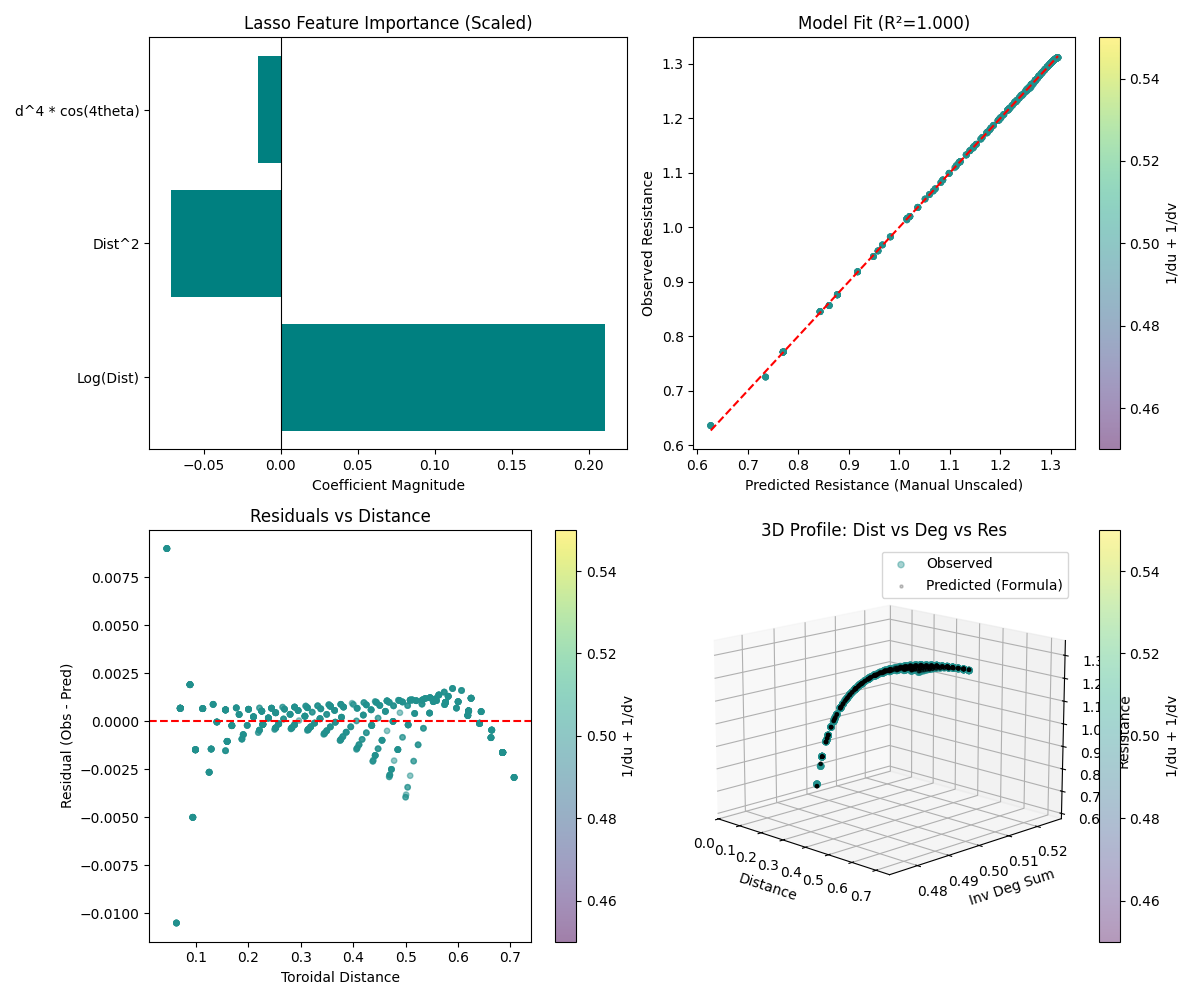

In [ ]:
%matplotlib widget

import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import warnings
import sys, os, webbrowser
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from RGG_Library import RGGBuilder, RGGVisualizer

# --------------------------------------------------------------------------------
# HELPER FUNCTIONS
# --------------------------------------------------------------------------------
def radius_multiplier_calc_square_lattice(dist, exp_k):
    return np.sqrt(exp_k / (dist**2 * np.pi))

# --------------------------------------------------------------------------------
# CONFIGURATION
# --------------------------------------------------------------------------------
SPACE                       = ["torus", "unit_square", "square_torus", "triangular_torus"][2]
USE_ANGLES                  = [True, False][0]
FEATURES                    = ["default", "lattice_with_no_perturbation"][1]
LASSO_ALPHA                 = 1e-6
CONNECTIVITY_REGIME         = ["sc","c"][0]

ORDER                       = 1
MAX_DIST_FOR_ORDER          = 1
DEGREE_FOR_ORDER            = 4

PERTURB                     = [True, False][1]
PERTURB_SCALE               = 1
PERTURB_RADIUS_MULTIPLIER   = radius_multiplier_calc_square_lattice(dist=MAX_DIST_FOR_ORDER, exp_k=DEGREE_FOR_ORDER)

N_NODES                     = 1024
K_NEIGHBORS                 = 4
N_SAMPLES                   = 1000
ITERATION                   = 0

# --------------------------------------------------------------------------------
# SIMULATION
# --------------------------------------------------------------------------------
def run_simulation(n=N_NODES, k=K_NEIGHBORS, nsamples=N_SAMPLES, iteration=ITERATION):
    print(f"\n===== SEED {iteration} =====")

    # --- RGG Generation ---
    builder = RGGBuilder(
        n=n, 
        k=k,
        connectivity_regime=CONNECTIVITY_REGIME,
        space=SPACE,
        order=ORDER,
        perturb=PERTURB,
        perturb_scale=PERTURB_SCALE,
        perturb_radius_multiplier=PERTURB_RADIUS_MULTIPLIER,
        seed=iteration
    )

    G = builder.build()

    # --- Ensure Giant Component ---
    if not nx.is_connected(G):
        components = list(nx.connected_components(G))
        Gsub = G.subgraph(max(components, key=len)).copy() if components else None
        if Gsub is None:
            print(f"Warning: Graph is empty in iteration {iteration}. Skipping.")
            return
    else:
        Gsub = G

    Gsub = nx.convert_node_labels_to_integers(Gsub, ordering="sorted")

    # builder.print_graph_stats(G, radius=builder.radius)
    # builder.plot_degree_distribution(Gsub)

    # --- Sampling ---
    random.seed(iteration)
    np.random.seed(iteration)

    if USE_ANGLES:
        res, degs, dists, pairs, angles = RGGBuilder.sample_commute_times_even_distance_w_angles(
            Gsub, nsamples=nsamples, n_bins=20, seed=iteration,
            min_dist=builder.radius, max_dist=2
        )
    else:
        res, degs, dists, pairs = RGGBuilder.sample_commute_times_even_distance(
            Gsub, nsamples=nsamples, n_bins=20, seed=iteration,
            min_dist=builder.radius, max_dist=2
        )

    if len(res) < 10:
        print("Not enough samples for Lasso regression.")
        return G, Gsub

    # --- Feature Engineering ---
    safe_dists = dists.copy()
    safe_dists[safe_dists == 0] = 1e-9
    current_angles = angles if USE_ANGLES else np.zeros_like(dists)

    if FEATURES == "default":  # "default" — lattice with no perturbation
        feature_dict = {
            "Dist^2":            dists**2,
            "Log(Dist)":         np.log(safe_dists),
            "d^4 * cos(4theta)": dists**4 * np.cos(4 * current_angles),
            "InvDegSum":         degs,
        }
    
    elif FEATURES == "lattice_with_no_perturbation":
        feature_dict = {
            "Log(Dist)":         np.log(safe_dists),
            "Dist^2":            dists**2,
            "d^4 * cos(4theta)": dists**4 * np.cos(4 * current_angles),
        }

    feature_names = list(feature_dict.keys())
    X = np.column_stack(list(feature_dict.values()))
    y = res

    # --- Lasso Regression ---
    print("\n--- Running Lasso ---")
    model = make_pipeline(
        StandardScaler(),
        Lasso(alpha=LASSO_ALPHA, random_state=0, max_iter=50000)
    )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X, y)

    # --- Extract Coefficients ---
    lasso  = model.named_steps['lasso']
    scaler = model.named_steps['standardscaler']

    scaled_coefs   = lasso.coef_
    sigmas         = scaler.scale_
    means          = scaler.mean_

    real_coefs     = scaled_coefs / sigmas
    real_intercept = lasso.intercept_ - np.sum(real_coefs * means)

    y_pred    = X @ real_coefs + real_intercept
    residuals = y - y_pred

    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2     = 1 - (ss_res / ss_tot)

    print(f"\nAlpha (User-defined): {lasso.alpha:.6f}")
    print(f"Lasso R² (Calculated from Real Coefs): {r2:.4f}")

    sorted_idx = np.argsort(np.abs(scaled_coefs))[::-1]

    print("\n[Scaled] Feature Importance (Relative Strength):")
    print("-" * 50)
    found_any = False
    for i in sorted_idx:
        if abs(scaled_coefs[i]) > 1e-6:
            print(f"{feature_names[i]:<20} : {scaled_coefs[i]:.6f}")
            found_any = True
    if not found_any:
        print("(Lasso shrank all coefficients to zero - try a smaller alpha)")
    print("-" * 50)

    print("\n[Unscaled] Physical Formula (True Units):")
    print(f"Real Intercept       : {real_intercept:.6f}")
    print("-" * 50)
    for i in sorted_idx:
        if abs(scaled_coefs[i]) > 1e-6:
            print(f"{feature_names[i]:<20} : {real_coefs[i]:.8f}")
    print("-" * 50)

    # --- Visualization ---
    cmap = "viridis"
    fig  = plt.figure(figsize=(12, 10))

    ax1 = fig.add_subplot(2, 2, 1)
    ax1.barh(feature_names, scaled_coefs, color='teal')
    ax1.axvline(0, color='k', linewidth=0.8)
    ax1.set_title("Lasso Feature Importance (Scaled)")
    ax1.set_xlabel("Coefficient Magnitude")

    ax2 = fig.add_subplot(2, 2, 2)
    sc1 = ax2.scatter(y_pred, y, c=degs, cmap=cmap, alpha=0.5, s=15)
    lims = [min(y.min(), y_pred.min()), max(y.max(), y_pred.max())]
    ax2.plot(lims, lims, 'r--', lw=1.5)
    ax2.set_title(f"Model Fit (R²={r2:.3f})")
    ax2.set_xlabel("Predicted Resistance (Manual Unscaled)")
    ax2.set_ylabel("Observed Resistance")
    plt.colorbar(sc1, ax=ax2, label="1/du + 1/dv")

    ax3 = fig.add_subplot(2, 2, 3)
    sc2 = ax3.scatter(dists, residuals, c=degs, cmap=cmap, alpha=0.5, s=15)
    ax3.axhline(0, color='r', linestyle='--')
    ax3.set_title("Residuals vs Distance")
    ax3.set_xlabel("Toroidal Distance")
    ax3.set_ylabel("Residual (Obs - Pred)")
    plt.colorbar(sc2, ax=ax3, label="1/du + 1/dv")

    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    sc3 = ax4.scatter(dists, degs, y, c=degs, cmap=cmap, alpha=0.4, s=20, label='Observed')
    ax4.scatter(dists, degs, y_pred, c='k', alpha=0.2, s=5, label='Predicted (Formula)')
    ax4.set_title("3D Profile: Dist vs Deg vs Res")
    ax4.set_xlabel("Distance")
    ax4.set_ylabel("Inv Deg Sum")
    ax4.set_zlabel("Resistance")
    ax4.legend()
    ax4.view_init(elev=15, azim=315)
    plt.colorbar(sc3, ax=ax4, label="1/du + 1/dv")

    plt.tight_layout()
    plt.show()
    return G, Gsub

# --------------------------------------------------------------------------------
# RUN
# --------------------------------------------------------------------------------
G, Gsub = run_simulation()